# US Top 5000 Box Office Movies Data Analysis

## 1. Introduction

![movie_pic](movie_pic.png)

People love watching movies and it is a wonderful relaxing way. The US theatrical markets are very well developed and America remains the biggest single market for movies. The US movie industry has grown over the five years to 2019 and industry revenue is estimated to grow 1.6% last year and reach $18.9 billion in 2019. Therefore the main aim for this project is to analyse the significant factors that affect the US domestic box office and worldwide box office.


In this project, I obtain the movie data by scraping the US top 5000 box office movie names from the website "The Numbers" and scraping the movies detail from OMDb API. Then I focus on exploring the relationship between movie's box office and different movie information for instance movie type, runtime, movie language, IMBb data and released time. Furthermore, I implement two classification algorithm desicion tree and random forest. Finally, the accuarcy of two models are compared using ROC curve. 


## 2. Movie Data Scraping
### 2.1 Web Scraping US Top 5000 Box Office Movies from "The Numbers"

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import json
import statistics
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp

First I get the top 5000 US movies' box office through web scraping. The website "The Numbers"(https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time) has 100 movies' box office information per page, therefore I scrap from 500 pages and save the movie title, domestic box office, international box office and worldwide box office into a file "moviedata.csv". 

In [2]:
web_pages = np.arange(start=1, stop=5001, step=100)  
for name in web_pages:
    if name == 1:
        url = 'https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time'
    else:    
        url = 'https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time' + '/' + str(name)
    page = requests.get(url)
    soup = BeautifulSoup(page.content,'lxml')
    table = soup.find_all('table')
    df = pd.read_html(str(table))[0]
    df.to_csv (r'moviedata.csv', index = None, header=False, mode='a') 

### 2.2 Scraping Detail Information about Movies from OMDb API 
Then, detail information about movies can be obtained through the use of the OMDb API. I use 5000 movie names that I got from Web scraping to extract more movie information including movie type, runtime, languages, awards, IMDb rate, released date, directors and actors.

In [3]:
#5000 movie names
movie = pd.read_csv("moviedata.csv",encoding="ISO-8859-1")['Movie']
movie_lst = []
for i in movie:
    movie_lst.append(i)  

#use OMDb API     
movie = []
mtype = []
runtime = []
language1 = []
language2 = []
language_num = []
awards = []
rate_IMDb = []
imdbVotes = []
released = []
director1 = []
director2 = []
actor1 = []
actor2 = []
actor3 = []
actor4 = []

for i in movie_lst:
    query = i
    try:
        res = requests.get('http://www.omdbapi.com/?t='+ query +'&apikey=ed0b600b')
        movie.append(res.json()['Title'])
    except:
        movie.append('N/A')
    try:
        mtype.append(res.json()['Genre'].split()[0])
    except:
        mtype.append('N/A')      
    try:
        runtime.append(res.json()['Runtime'])
    except:
        runtime.append("N/A") 
    try:
        language1.append(res.json()['Language'].split()[0])
    except:
        language1.append('N/A')         
    try:
        language2.append(res.json()['Language'].split()[1])
    except:
        language2.append('N/A')        
    try:    
        language_num.append(len(res.json()['Language'].split()))     
    except:
        language_num.append('N/A')               
    try:
        awards.append(res.json()['Awards'])
    except:
        awards.append('N/A')  
    try:
        rate_IMDb.append(res.json()['Ratings'][0]['Value'].split('/')[0]) 
    except:
        rate_IMDb.append('N/A')
    try:
        imdbVotes.append(res.json()['imdbVotes'])
    except:
        imdbVotes.append('N/A')        
    try:
        released.append(res.json()['Released'])
    except:
        released.append('N/A')                 
    try:
        director1.append(res.json()['Director'].split(',')[0])
    except:
        director1.append('N/A')        
    try:
        director2.append(res.json()['Director'].split(',')[1]) 
    except: 
        director2.append('N/A')           
    try:
        actor1.append(res.json()['Actors'].split(',')[0])
    except:
        actor1.append('N/A')        
    try:
        actor2.append(res.json()['Actors'].split(',')[1])
    except:
        actor2.append('N/A')    
    try:
        actor3.append(res.json()['Actors'].split(',')[2])
    except:
        actor3.append('N/A')        
    try:
        actor4.append(res.json()['Actors'].split(',')[3])
    except:
        actor4.append('N/A')              

After the movies' detail information is downloaded, I save these information to file "moviedetail.csv".

In [4]:
movie_data = pd.DataFrame(
    {'Movie': movie,
     'Movie Type': mtype,
     'Runtime': runtime,
     'Language1': language1,
     'Language2': language2,
     'Language Number': language_num,     
     'Awards': awards,  
     'IMDb rate': rate_IMDb,     
     'imdbVotes': imdbVotes,
     'Released': released     
     'Director1': director1,
     'Director2': director2,
     'Actor1': actor1,
     'Actor2': actor2,
     'Actor3': actor3,
     'Actor4': actor4,
    })
movie_data.to_csv (r'moviedetail.csv', index = None, header = True, mode = 'a') 

Now we have 2 files, "moviedata.csv" and "moviedetail.csv":
- "moviedata.csv" contains names of US top 5000 box office movies and their domestic box office, international box office and worldwise box office.
- "moviedetail.csv" has detail information about movies such as movie type, runtime, languages, awards, IMDb rate, released date, directors and actors.

## 3. Data Cleansing and Manipulation 
Once movie data is gained, I clean the raw data in order to imporve the accuarcy of analysis.

Firstly I clean the file "moviedata.csv" by deleting the dollor sign($), thousand separator(,) for all box office value, and then converting their type to integers.

In [6]:
movie_box = pd.read_csv("moviedata.csv",encoding="ISO-8859-1").drop('Movie', axis=1) #Movie title column is removed
#delet the dollor sign($), thousand separator(,) for all box office value, and then convert their type to integers.
movie_box['Domestic\nBox Office'] = [int(i.replace(',','')) for i in movie_box['Domestic\nBox Office'].str[1:]]
international_box_office = []
for i in movie_box['International Box Office'].str[1:]:
    if type(i)==float:
        international_box_office.append(i)
    else:
        international_box_office.append(int(i.replace(',','')))
movie_box['International Box Office'] = international_box_office
movie_box['Worldwide Box Office'] = [int(i.replace(',','')) for i in movie_box['Worldwide Box Office'].str[1:]]

print('The mean domestic box office for top 5000 movies is ' + str('%.0f' % movie_box['Domestic\nBox Office'].mean()))
print('The mean worldwide box office for top 5000 movies is ' + str('%.0f' % movie_box['Worldwide Box Office'].mean()))

The mean domestic box office for top 5000 movies is 57755062
The mean worldwide box office for top 5000 movies is 116880575


Add 2 binary variables "Domestic Box Office Level" and "Worldwide Box Office Level", equals to 1 if box office above the mean box office level, 0 otherwise.

In [7]:
domestic_box_office_level = []
worldwide_box_office_level = []
for i in movie_box['Domestic\nBox Office']:
    if i < 57755062:
        domestic_box_office_level.append('low')
    else:
        domestic_box_office_level.append('high')
for i in movie_box['Worldwide Box Office']:
    if i < 116880575:
        worldwide_box_office_level.append(0)
    else:
        worldwide_box_office_level.append(1)        
movie_box['Domestic Box Office Level'] = domestic_box_office_level
movie_box['Worldwide Box Office Level'] = worldwide_box_office_level
movie_box.head()

,Rank,Year,Domestic\nBox Office,International Box Office,Worldwide Box Office,Domestic Box Office Level,Worldwide Box Office Level
0,1,2015,936662225,1.131561e+09,2068223624,high,1
1,2,2019,858373000,1.939428e+09,2797800564,high,1
2,3,2009,760507625,2.029198e+09,2789705275,high,1
3,4,2018,700059566,6.468536e+08,1346913161,high,1
4,5,2018,678815482,1.369544e+09,2048359754,high,1


Secondly I clean the file "moviedetail.csv" by removing the character 'min' and thousand separator as well as dropping the blank space. Also I add a variable 'Released Month' which is the movies' released month and a variable 'IMDb rate' which round all IMDb rates to integers. 

In [8]:
movie_info = pd.read_csv('moviedetail.csv')
movie_info['IMDb rate'] = [float(i) for i in movie_info['IMDb rate']]
movie_info['Runtime'] = movie_info['Runtime'].str.replace(' min', '').astype(float) #remove 'min' in Runtime column
movie_info['imdbVotes'] = [float(str(i).replace(',', '')) for i in movie_info['imdbVotes']] #remove the thousand separator
movie_info['Language1'] = [str(i).replace(' ', '') for i in movie_info['Language1']]
movie_info['Language2'] = [str(i).replace(' ', '') for i in movie_info['Language2']]
#extract released month
movie_months = [] 
for i in movie_info['Released'].str.split('-'):
    if type(i) == float:
        movie_months.append(i)
    else:
        movie_months.append(i[1])
movie_info['Released Month'] = movie_months  
#round IMDb rates
IMDb_rate = []
for i in movie_info['IMDb rate']:
    if str(i) == 'nan':
        IMDb_rate.append(i)
    else:
        IMDb_rate.append(round(i))
movie_info['IMDb rate'] = IMDb_rate

print(movie_info['Movie Type'].value_counts())

Comedy           1435
Action           1253
Drama             695
Adventure         327
Animation         279
Crime             278
Biography         261
Horror            243
Documentary        92
Fantasy            23
Mystery            20
Short              20
Family             10
Western             6
Thriller            6
Sci-Fi              5
Romance             4
Musical             2
Talk-Show           1
Adult               1
News                1
Reality-TV          1
ActionKnowing       1
Name: Movie Type, dtype: int64


We observe that the number of movies for genres after 'Short' are less that 10 which menas those genres contribute nearly 0.00%. Thus I replace those movie types to 'other'. 

In [9]:
top12_genres =movie_info['Movie Type'].value_counts()[:12].index
top_genres = []
for i in movie_info['Movie Type']:
    if i in top12_genres:
        top_genres.append(i)
    else:
        top_genres.append('other')
movie_info['Movie Type'] =  top_genres
movie_info.head()

,Movie,Movie Type,Runtime,Language1,Language2,Language Number,Awards,IMDb rate,imdbVotes,Released,Director1,Director2,Actor1,Actor2,Actor3,Actor4,Released Month
0,Star Wars: The Force Awakens World Premiere Re...,other,108.0,English,nan,1.0,NaN,6.0,NaN,14-Dec-15,NaN,NaN,J.J. Abrams,John Boyega,Anthony Carboni,Gwendoline Christie,Dec
1,Avengers: Endgame,Action,181.0,English,Japanese,4.0,Nominated for 1 BAFTA Film Award. Another 32 w...,8.0,640310.0,26-Apr-19,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Apr
2,Avatar,Action,162.0,English,Spanish,2.0,Won 3 Oscars. Another 86 wins & 129 nominations.,8.0,1073469.0,18-Dec-09,James Cameron,NaN,Sam Worthington,Zoe Saldana,Sigourney Weaver,Stephen Lang,Dec
3,Black Panther,Action,134.0,English,Swahili,5.0,Won 3 Oscars. Another 101 wins & 246 nominations.,7.0,555834.0,16-Feb-18,Ryan Coogler,NaN,Chadwick Boseman,Michael B. Jordan,Lupita Nyong'o,Danai Gurira,Feb
4,Avengers: Infinity War,Action,149.0,English,nan,1.0,Nominated for 1 Oscar. Another 44 wins & 64 no...,8.0,732619.0,27-Apr-18,Anthony Russo,Joe Russo,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,Chris Evans,Apr


After all, I concat two dataframe and set the movie rank as index.

In [10]:
movies = pd.concat([movie_info, movie_box], axis=1) #concat two dataframe 
movie_clean = movies[pd.notna(movies['Movie'])].set_index('Rank') #set movie rank as index
movie_clean.head()

,Movie,Movie Type,Runtime,Language1,Language2,Language Number,Awards,IMDb rate,imdbVotes,Released,...,Actor2,Actor3,Actor4,Released Month,Year,Domestic\nBox Office,International Box Office,Worldwide Box Office,Domestic Box Office Level,Worldwide Box Office Level
Rank,,,,,,,,,,,,,,,,,,,,,
1,Star Wars: The Force Awakens World Premiere Re...,other,108.0,English,nan,1.0,NaN,6.0,NaN,14-Dec-15,...,John Boyega,Anthony Carboni,Gwendoline Christie,Dec,2015,936662225,1.131561e+09,2068223624,high,1
2,Avengers: Endgame,Action,181.0,English,Japanese,4.0,Nominated for 1 BAFTA Film Award. Another 32 w...,8.0,640310.0,26-Apr-19,...,Chris Evans,Mark Ruffalo,Chris Hemsworth,Apr,2019,858373000,1.939428e+09,2797800564,high,1
3,Avatar,Action,162.0,English,Spanish,2.0,Won 3 Oscars. Another 86 wins & 129 nominations.,8.0,1073469.0,18-Dec-09,...,Zoe Saldana,Sigourney Weaver,Stephen Lang,Dec,2009,760507625,2.029198e+09,2789705275,high,1
4,Black Panther,Action,134.0,English,Swahili,5.0,Won 3 Oscars. Another 101 wins & 246 nominations.,7.0,555834.0,16-Feb-18,...,Michael B. Jordan,Lupita Nyong'o,Danai Gurira,Feb,2018,700059566,6.468536e+08,1346913161,high,1
5,Avengers: Infinity War,Action,149.0,English,nan,1.0,Nominated for 1 Oscar. Another 44 wins & 64 no...,8.0,732619.0,27-Apr-18,...,Chris Hemsworth,Mark Ruffalo,Chris Evans,Apr,2018,678815482,1.369544e+09,2048359754,high,1


## 4. Exploratory Data Analysis of Movie Data
### 4.1 Number of US Top Box Office Movies in Different Years

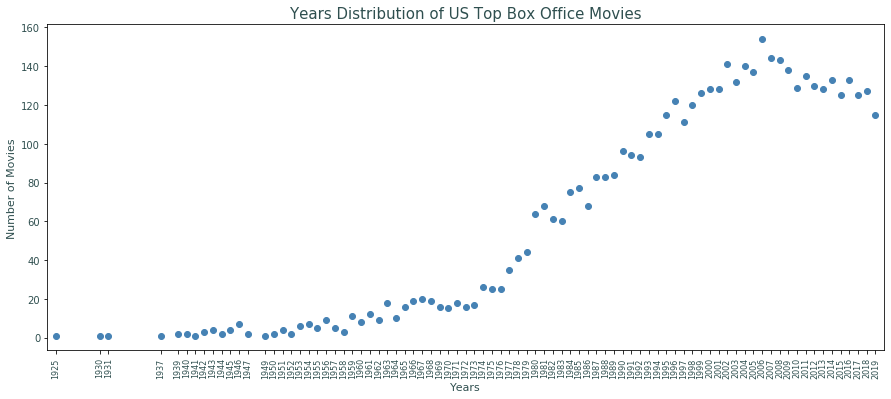

The number of movies in the peak time(2006) is 154


In [11]:
movie_count = movie_clean['Year'].value_counts().tolist()
movie_years = movie_clean['Year'].value_counts().index
fig, axes = plt.subplots(figsize=(15,6))
plt.scatter(movie_years ,movie_count, color='steelblue')
axes.set_xlabel('Years', fontsize=11, color='darkslategray')
axes.set_ylabel('Number of Movies', fontsize=11, color='darkslategray')
axes.set_title('Years Distribution of US Top Box Office Movies',fontsize=15, color='darkslategray')
plt.xticks(movie_years, rotation=90, fontsize=8, color='darkslategray')
plt.yticks(color='darkslategray')
plt.xlim(1924,2020)
plt.show()

print('The number of movies in the peak time(2006) is ' + str(movie_clean['Year'].value_counts()[2006]))

As shown in scatter plot above, the number of movies in US top 5000 box office began to growth slowly from 1925, and had a significantly raise between 1970 and 2006, then reached a peak in 2006. However the number decreased slightly after 2006. Before 1956, the number of movies for each year are all less than 10. Therefore, in this project, I ignore  those movies before 1956.

In [12]:
movie_clean = movie_clean[movie_clean['Year'] >= 1956]

### 4.2 Average Box Office in Different Years

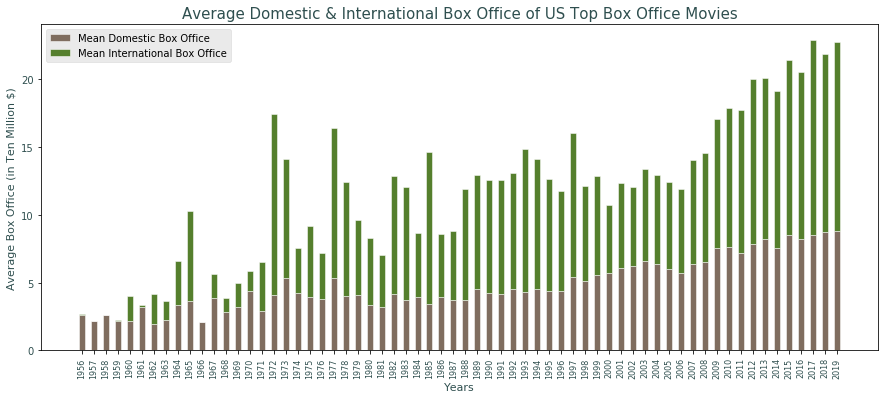

In [13]:
movie_years = list(set(movie_clean['Year'].tolist())) #a new list of years(years after 1956)
domestic_mean = [] #a list of mean domestic box office
international_mean = [] #a list of international domestic box office
for i in movie_years:
    domestic_mean.append(statistics.mean(movie_clean.groupby('Year')['Domestic\nBox Office'].apply(list)[i]))
    int_boxoffice = [i for i in movie_clean.groupby('Year')['International Box Office'].apply(list)[i] if str(i) != 'nan']
    international_mean.append(statistics.mean(int_boxoffice))
international_mean = [v/10000000 for v in international_mean]    
domestic_mean = [v/10000000 for v in domestic_mean]

fig, axes = plt.subplots(figsize=(15,6))
plt.style.use('ggplot')
bars = np.add(domestic_mean, international_mean).tolist()
r = range(len(movie_years))   
barWidth = 0.5 
plt.bar(r, domestic_mean, color='#7f6d5f', edgecolor='white', width=barWidth) #Create brown bars
plt.bar(r, international_mean, bottom=domestic_mean, color='#557f2d', edgecolor='white', width=barWidth) #Create green bars, on top of the firs ones
axes.set_xlabel('Years', fontsize=11, color='darkslategray')
axes.set_ylabel('Average Box Office (in Ten Million $)', fontsize=11, color='darkslategray')
axes.set_title('Average Domestic & International Box Office of US Top Box Office Movies',fontsize=15, color='darkslategray')
plt.xticks(r, movie_years, rotation=90, fontsize=8, color='darkslategray')
plt.yticks(color='darkslategray')
plt.legend(['Mean Domestic Box Office', 'Mean International Box Office'],loc=2)
plt.show()

The brown bar indicates US domestic box office and the green bar indicates international box office, therefore the whole bar represents the worldwide box office for US top 5000 box office movies. Even though we observe some little fluctuations in worldwide box office between 1972 to 1997, the overall tend of average domestic box office and average worldwide box office are increasing over the years. 
### 4.3 Movie Genres Classification

The distribution of genres for top 5000 movies:


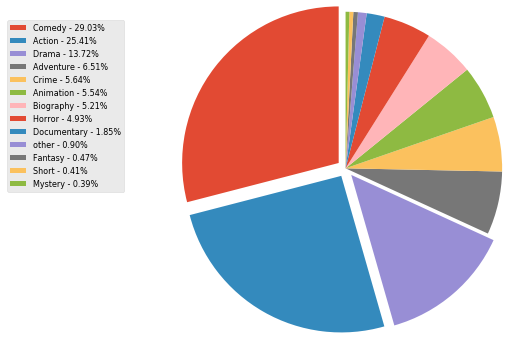

In [14]:
print('The distribution of genres for top 5000 movies:')
movie_type = list(movie_clean['Movie Type'].value_counts().index)
type_num = movie_clean['Movie Type'].value_counts().tolist()
fig1, ax1 = plt.subplots(figsize=(4, 4))
explode = [0] * 13
explode[:3] = [0.1, 0.1, 0.1]
type_per = ["%.2f" % (100*int(i)/sum(type_num)) + '%' for i in type_num]
patches, texts = plt.pie(type_num, explode=explode, startangle=90, radius=1.8)
labels = ['{0} - {1}'.format(i,j) for i,j in zip(movie_type, type_per)]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, type_num),
                                          key=lambda x: x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.5, 1.2),
           fontsize=8)
plt.show()

From the pie chart distribution of movie genres, we can see clearly that out of the 5000 US highest-grossing movies, comedy and action are two most popular movie types which contribute 29.03% and 25.41% respectively.  

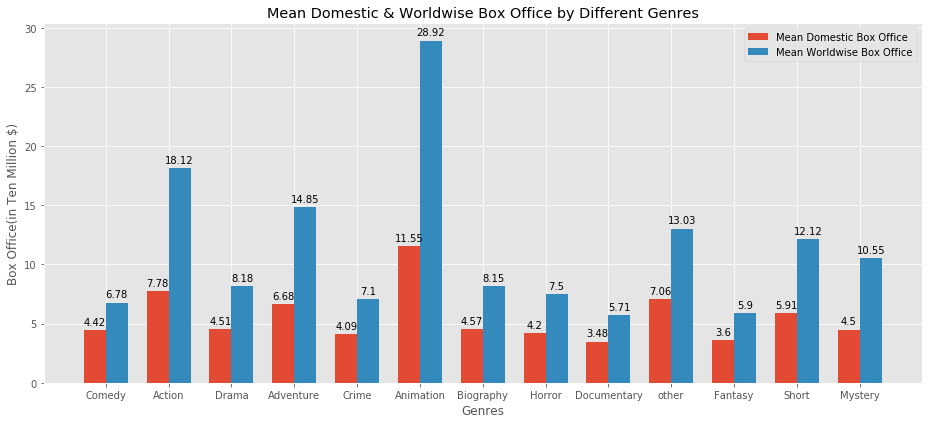

In [15]:
genre_domestic_mean = []
genre_worldwise_mean = []
for i in movie_type: 
    genre_domestic_mean.append(movie_clean[movie_clean['Movie Type'] == i]['Domestic\nBox Office'].mean())
    genre_worldwise_mean.append(movie_clean[movie_clean['Movie Type'] == i]['Worldwide Box Office'].mean())
genre_domestic_mean = [float("%.2f" % (i/10000000)) for i in genre_domestic_mean]
genre_worldwise_mean = [float("%.2f" % (i/10000000)) for i in genre_worldwise_mean]

x = np.arange(len(movie_type))  
width = 0.35  
fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - width/2, genre_domestic_mean, width, label='Mean Domestic Box Office')
rects2 = ax.bar(x + width/2, genre_worldwise_mean, width, label='Mean Worldwise Box Office')
ax.set_ylabel('Box Office(in Ten Million $)')
ax.set_xlabel('Genres')
ax.set_title('Mean Domestic & Worldwise Box Office by Different Genres')
ax.set_xticks(x)
ax.set_xticklabels(movie_type)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

The bar plot above shows mean domestic box office and mean worldwide box office by different genres, top three movies that have highest box office are animation, action and adventure. And clearly, animation occupy an absolute superiority.
### 4.4 Analysis of IMDb Rate

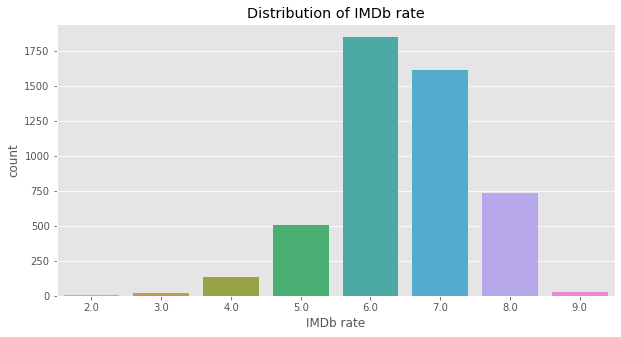

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(movie_clean['IMDb rate'])
plt.title('Distribution of IMDb rate')
plt.xlabel('IMDb rate')
plt.show()

The bar chart shows that, the most frenqucy iMDb rate for US top box office movies is 6.0.

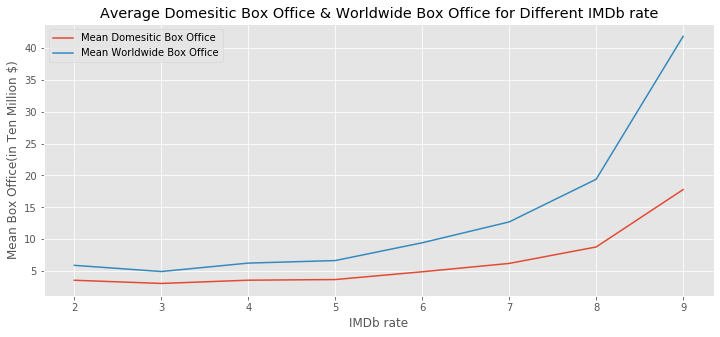

In [17]:
iMDb_rates = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
iMDb_domesitic_mean = []
iMDb_world_mean = []
for i in iMDb_rates:
    iMDb_domesitic_mean.append(statistics.mean(movie_clean.groupby('IMDb rate')['Domestic\nBox Office'].apply(list)[i]))
    iMDb_world_mean.append(statistics.mean(movie_clean.groupby('IMDb rate')['Worldwide Box Office'].apply(list)[i])) 
iMDb_domesitic_mean = [float("%.2f" % (i/10000000)) for i in iMDb_domesitic_mean]
iMDb_world_mean = [float("%.2f" % (i/10000000)) for i in iMDb_world_mean] 
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.title("Average Domesitic Box Office & Worldwide Box Office for Different IMDb rate")
plt.xlabel("IMDb rate")
plt.ylabel("Mean Box Office(in Ten Million $)")
plt.plot(iMDb_rates, iMDb_domesitic_mean,'-',label="Mean Domesitic Box Office")
plt.plot(iMDb_rates, iMDb_world_mean,'-',label="Mean Worldwide Box Office")
plt.legend()
plt.grid(True)

As IMDb rate increasing, both domesitic box office and worldwide box office raise. 
### 4.5 Scatterplot of  Runtime and Worldwide Box Office 

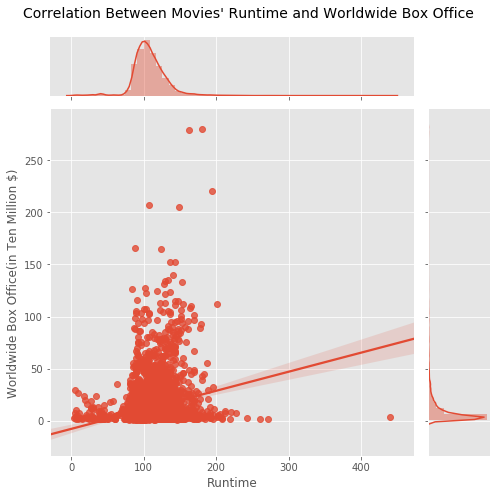

In [18]:
world_box_office = [float("%.1f" % (i/10000000)) for i in movie_clean['Worldwide Box Office']]
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
camp = sns.jointplot(data=movie_clean,x='Runtime',y=world_box_office, kind="reg", height=7)
camp.fig.suptitle('Correlation Between Movies\' Runtime and Worldwide Box Office', size=14)
camp.set_axis_labels("Runtime", "Worldwide Box Office(in Ten Million $)")
camp.fig.tight_layout()
camp.fig.subplots_adjust(top=0.92)

From above scatter plot, we observe that most of the runtime of US top box office is about 100 min which is the most popular length of a movie nowadays as well. There is a weak positive linear association between movie's runtime and worldwide box office.

### 4.6 Movie Performance in Different Months

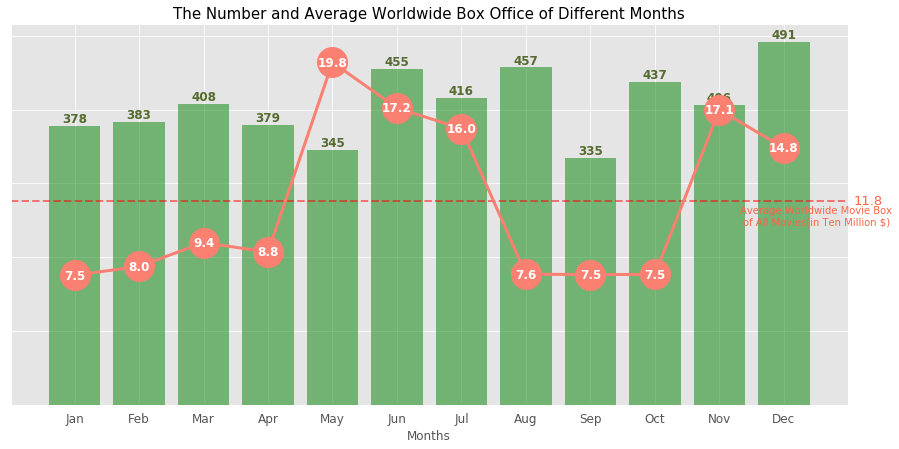

In [19]:
Worldwide_data = movie_clean.groupby('Released Month')['Movie', 'Worldwide Box Office'].agg({'Movie': 'count', 'Worldwide Box Office': 'mean'}).sort_values(by='Movie', ascending=False)
Worldwide_data['Worldwide Box Office'] = [float("%.2f" % (i/10000000)) for i in Worldwide_data['Worldwide Box Office']]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec']
month_count = []
month_worldwide = []
for i in month_names:
    month_count.append(Worldwide_data['Movie'][i])
    month_worldwide.append(Worldwide_data['Worldwide Box Office'][i])   

fig, ax1 = plt.subplots(figsize=(15,7)) #bar plot for month count
plt.title('The Number and Average Worldwide Box Office of Different Months', fontsize=15)
ax1.set_xlabel('Months')
ax1.grid(zorder=0)
y_pos = np.arange(len(month_names))
plt.bar(month_names, month_count, align='center', alpha=0.5, color='g', zorder=5)
ax1.set_xticklabels(month_names, fontsize=12)

x1 = np.arange(len(month_names)) #tag the number of movies in each month
y1 = month_count
for x,y in zip(x1, y1):
    ax1.annotate(y, xy=(x,y+10), color='darkolivegreen', fontsize=12, weight='bold', ha='center', va='center')
ax1.tick_params(bottom=False, left=False, right=False, labelleft=False, color='white')

ax2 = ax1.twinx() #plot mean domestic box office
ax2.grid(False)
ax2.set_ylim(0, 22)
month_worldwide_mean = float('%.2f' % (movie_clean['Worldwide Box Office'].mean()/10000000))
ax2.axhline(month_worldwide_mean, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.plot(month_worldwide, color = 'salmon', marker='o', markersize=30, linewidth=3)
ax2.tick_params(bottom=True, left=False, right=False, labelright=False, labelbottom=False)

x2 = np.arange(len(month_names)) #tage mean domestic box office
y2 = month_worldwide
for x,y in zip(x2, y2):
    ax2.annotate(round(y,1), xy=(x,y), color='white', fontsize=12, weight='bold', ha='center', va='center')
    
ax2.annotate('Average Worldwide Movie Box\nof All Movies(in Ten Million $)', xy=(11+0.5, month_worldwide_mean-0.9), color='tomato', fontsize=10, ha='center', va='center')
ax2.text(12+0.3, month_worldwide_mean, round(month_worldwide_mean,1), color='tomato', fontsize=13, ha='center', va='center')    
plt.show()

From the figure above, we can see that most of the US top box office movies were released in December(491 movies). Movies that released in May, June, November, July and December have quite high worldwide box office(over the mean worldwide box office).

### 4.7 Relationship between Languages and Movies
A lot of movies have multiple-language version, I count first several poplular languages has been used in US top box office movies and apparently, english is the language has been used most often.

In [20]:
language_all = movie_clean['Language1'].tolist() + movie_clean['Language2'].tolist()
for i, j in Counter(language_all).most_common():
    if i == 'nan' or j <= 50:
        continue
    else:
        print(i, j)

English 4839
Spanish 394
French 306
German 153
Italian 134
Russian 129
Japanese 86
Mandarin 59


In [21]:
languages_worldwide_data = movie_clean.groupby('Language Number')['Movie', 'Worldwide Box Office'].agg({'Movie': 'count', 'Worldwide Box Office': 'mean'}).sort_values(by='Movie', ascending=False)
languages_worldwide_data['Worldwide Box Office'] = [float("%.2f" % (i/10000000)) for i in languages_worldwide_data['Worldwide Box Office']]
languages_worldwide_data

,Movie,Worldwide Box Office
Language Number,,
1.0,3156,9.88
2.0,1006,13.48
3.0,387,15.23
4.0,211,18.57
5.0,83,21.60
6.0,35,23.37
7.0,19,26.25
8.0,9,12.67
9.0,5,19.31


Most movies are in one language only and we observe that the box office tend to be larger for movies that have more numebr of languages, which make sense, because larger number of languages means people from more country are able to watch it. When number of languages equals to 10 there is a daramictlly raise, however there is only one movie have 10 languages version, the result tend to be biased. 

### 4.8 Key Words
As shown in figure below, the famous word in awards of US top box office movies are 'wins', 'nominations', 'Oscar' and 'Golden Globe'. 

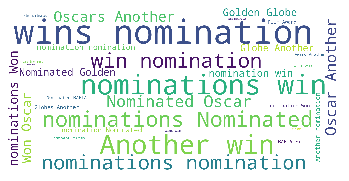

In [22]:
all_awards = [i for i in movie_clean['Awards'] if type(i) != float]
wordcloud1 = WordCloud(width=1000, height=500, scale=2,background_color='white').generate(' '.join(all_awards))
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

In [23]:
director_all = movie_clean['Director1'].tolist() + movie_clean['Director2'].tolist()
print('Most popular directors in top 5000 US box office movies are:\n')
for i, j in Counter(director_all).most_common():
    if str(i) == 'nan' or j <= 20:
        continue
    else:
        print(i, j)

Most popular directors in top 5000 US box office movies are:

Clint Eastwood 33
Steven Spielberg 30
Woody Allen 26
Ron Howard 24


In [24]:
actor_all = movie_clean['Actor1'].tolist() + movie_clean['Actor2'].tolist() + movie_clean['Actor3'].tolist() + movie_clean['Actor4'].tolist()
print('Most popular actors in top 5000 US box office movies are:\n')
for i, j in Counter(actor_all).most_common():
    if str(i) == 'nan' or j <= 30:
        continue
    else:
        print(i, j)

Most popular actors in top 5000 US box office movies are:

Tom Hanks 35
Bruce Willis 33
Clint Eastwood 32
Robert De Niro 31
Sylvester Stallone 31


## 5. Data Modelling

First, I create a dataframe with factors might affect worldwide box office such as: movie genres, runtime, number of languages, IMDb rate, IMDb votes, released month, released year, and if movies's domestic box office is above the mean domestic box office. Then, I change all categorical variables into dummy varibles and I split the data to train data(70%) and test data(30%).

In [25]:
movie_df =  movie_clean[['Worldwide Box Office Level','Movie Type','Runtime','Language Number','IMDb rate','imdbVotes','Released Month','Year','Domestic Box Office Level']]
all_dummy_movie = pd.get_dummies(movie_df)
mean_cols = all_dummy_movie.mean()
all_dummy_movie = all_dummy_movie.fillna(mean_cols) #fill with mean value
X = all_dummy_movie.iloc[:, 1:]
y = all_dummy_movie.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
all_dummy_movie.head()

,Worldwide Box Office Level,Runtime,Language Number,IMDb rate,imdbVotes,Year,Movie Type_Action,Movie Type_Adventure,Movie Type_Animation,Movie Type_Biography,...,Released Month_Jan,Released Month_Jul,Released Month_Jun,Released Month_Mar,Released Month_May,Released Month_Nov,Released Month_Oct,Released Month_Sep,Domestic Box Office Level_high,Domestic Box Office Level_low
Rank,,,,,,,,,,,,,,,,,,,,,
1,1,108.0,1.0,6.0,1.141494e+05,2015,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,181.0,4.0,8.0,6.403100e+05,2019,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,162.0,2.0,8.0,1.073469e+06,2009,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,134.0,5.0,7.0,5.558340e+05,2018,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,149.0,1.0,8.0,7.326190e+05,2018,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 5.1 Desicion Tree

In [30]:
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
print('Confusion matrix of Decision Tree: ')
print(confusion_matrix(y_test,tree_pred))

Confusion matrix of Decision Tree: 
[[1001   92]
 [  91  290]]


### 5.2 Random Forest

In [31]:
forest = RandomForestClassifier(n_estimators=100, random_state = 0)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)
print('Confusion matrix of random forest: ')
print(confusion_matrix(y_test,forest_pred))

Confusion matrix of random forest: 
[[1032   61]
 [  76  305]]


### 5.3 ROC Curve of Classification Algorithm

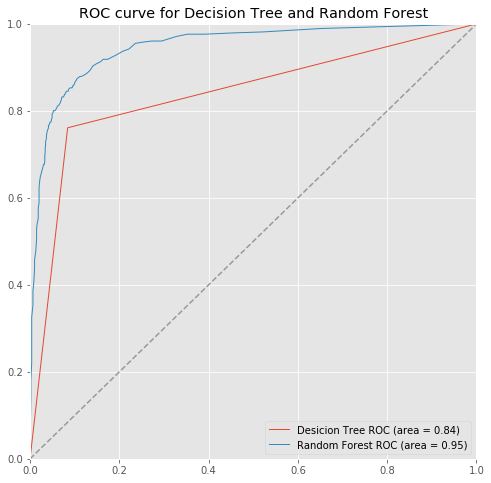

In [32]:
fig = plt.figure(figsize=(8, 8))
probas1 = tree.fit(X_train, y_train).predict_proba(X_test)
probas2 = forest.fit(X_train, y_train).predict_proba(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_test, probas1[:, 1], pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probas2[:, 1], pos_label=1)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr1, tpr1, lw=1, label='Desicion Tree ROC (area = %0.2f)' 
                    % ( roc_auc1))
plt.plot(fpr2, tpr2, lw=1, label='Random Forest ROC (area = %0.2f)' 
                    % ( roc_auc2))
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6))
plt.title('ROC curve for Decision Tree and Random Forest')
plt.legend(loc="lower right")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

The area under the curve is a measure of test accuracy, the closer the curve comes to the 45-degree diagonal(dash line) of the ROC space, the less accurate the test. We can see from the ROC curve above, random forest is more accurate in comparison to decision tree.

## 6. Conclusion

In conclusion, the performance of US movie industry is getting better and better in recent years. The number of movies in top 5000 box office and mean box office of movies raisein recent year.


Comedy, action and drama are top 3 popular movie types in US top 5000 box office movies. However top 3 movies with highest mean box office are animation, action and adventure. Movie's box office increase as IMDb rate increase, but IMDb vote and box office of movie only have weak correlation. It's obviously most of US top box office was released in December and movies released in May have the highest mean box office. 


From the ROC curve of decision tree and random forest, we observe that random forest is more accurate with fairly high accuracy 0.95.